# 마케팅 투입 요소에 따른 전환 가입자 분석

## 1. 분석 개요

각 주 별로 자사 프로모션 금액, 경쟁사 프로모션 금액, 특정 요금제에 대한 할인, 혜택 제공 등의 마케팅 투입(X값)에 따라서 자사로의 전환 가입자가 어떻게 되는지를 파악하고자 합니다. 이를 통해 마케팅 요소들이 전환 가입자 수에 어느 정도 기여하는지 분석합니다. 

분석 기법으로는 마케팅 믹스 모델(Marketing Mix Model)을 사용하며, 시계열 조정을 한 후 회귀 분석을 통해 마케팅 요소의 기여 효과를 파악합니다.

단, 실무에서는 [Robyn](https://www.facebookblueprint.com/student/path/267249-meta-robyn)이 많이 사용되나, Robyn을 구동하려면 R을 설정하는 등의 절차가 필요하기 때문에 여기에서는 개념 설명을 위한 다른 기법으로 진행합니다. 마케팅 믹스 모델을 더 develop한다면 Robyn 혹은 LightweightMMM을 사용하게 될 예정이나, 아래 코드에서는 이를 위한 개념 이해에 중점을 두었습니다.

## 2. 데이터 생성 및 전처리

먼저, 각 주 별 마케팅 투입 요소와 전환 가입자 데이터를 생성하고 전처리합니다. 어떤 형태의 데이터가 필요한지 눈여겨 봐주세요.


In [1]:
import pandas as pd
import numpy as np

# 샘플 데이터 생성
np.random.seed(42)
num_samples = 104  # 2년치 데이터

weeks = pd.date_range(start='2022-01-01', periods=num_samples, freq='W')
promo_spend = np.round(np.random.uniform(1000, 5000, num_samples))  # 자사 프로모션 금액
competitor_promo_spend = np.round(np.random.uniform(500, 3000, num_samples))  # 경쟁사 프로모션 금액
discounts = np.round(np.random.uniform(0, 50, num_samples))  # 특정 요금제에 대한 할인 (백분율)
benefits = np.round(np.random.uniform(0, 100, num_samples))  # 혜택 제공 (포인트 등)
conversions = np.round(promo_spend * 0.3 + competitor_promo_spend * -0.2 + discounts * 0.5 + benefits * 0.1 + np.random.normal(0, 50, num_samples))  # 전환 가입자 수

# 데이터프레임 생성
data = pd.DataFrame({
    'Week': weeks,
    'PromoSpend': promo_spend,
    'CompetitorPromoSpend': competitor_promo_spend,
    'Discounts': discounts,
    'Benefits': benefits,
    'Conversions': conversions
})

# 데이터 확인
data.head()

,Week,PromoSpend,CompetitorPromoSpend,Discounts,Benefits,Conversions
0,2022-01-02,2498.0,2769.0,0.0,3.0,146.0
1,2022-01-09,4803.0,1123.0,8.0,96.0,1169.0
2,2022-01-16,3928.0,1526.0,27.0,84.0,953.0
3,2022-01-23,3395.0,2389.0,35.0,70.0,605.0
4,2022-01-30,1624.0,1072.0,33.0,41.0,325.0


## 3. 시계열 조정

시계열 데이터를 분석할 때는 데이터의 트렌드, 시즌성, 그리고 잔차 요소를 분리하여 살펴보는 것이 중요합니다. 이를 위해 시계열 분해를 수행해보겠습니다.


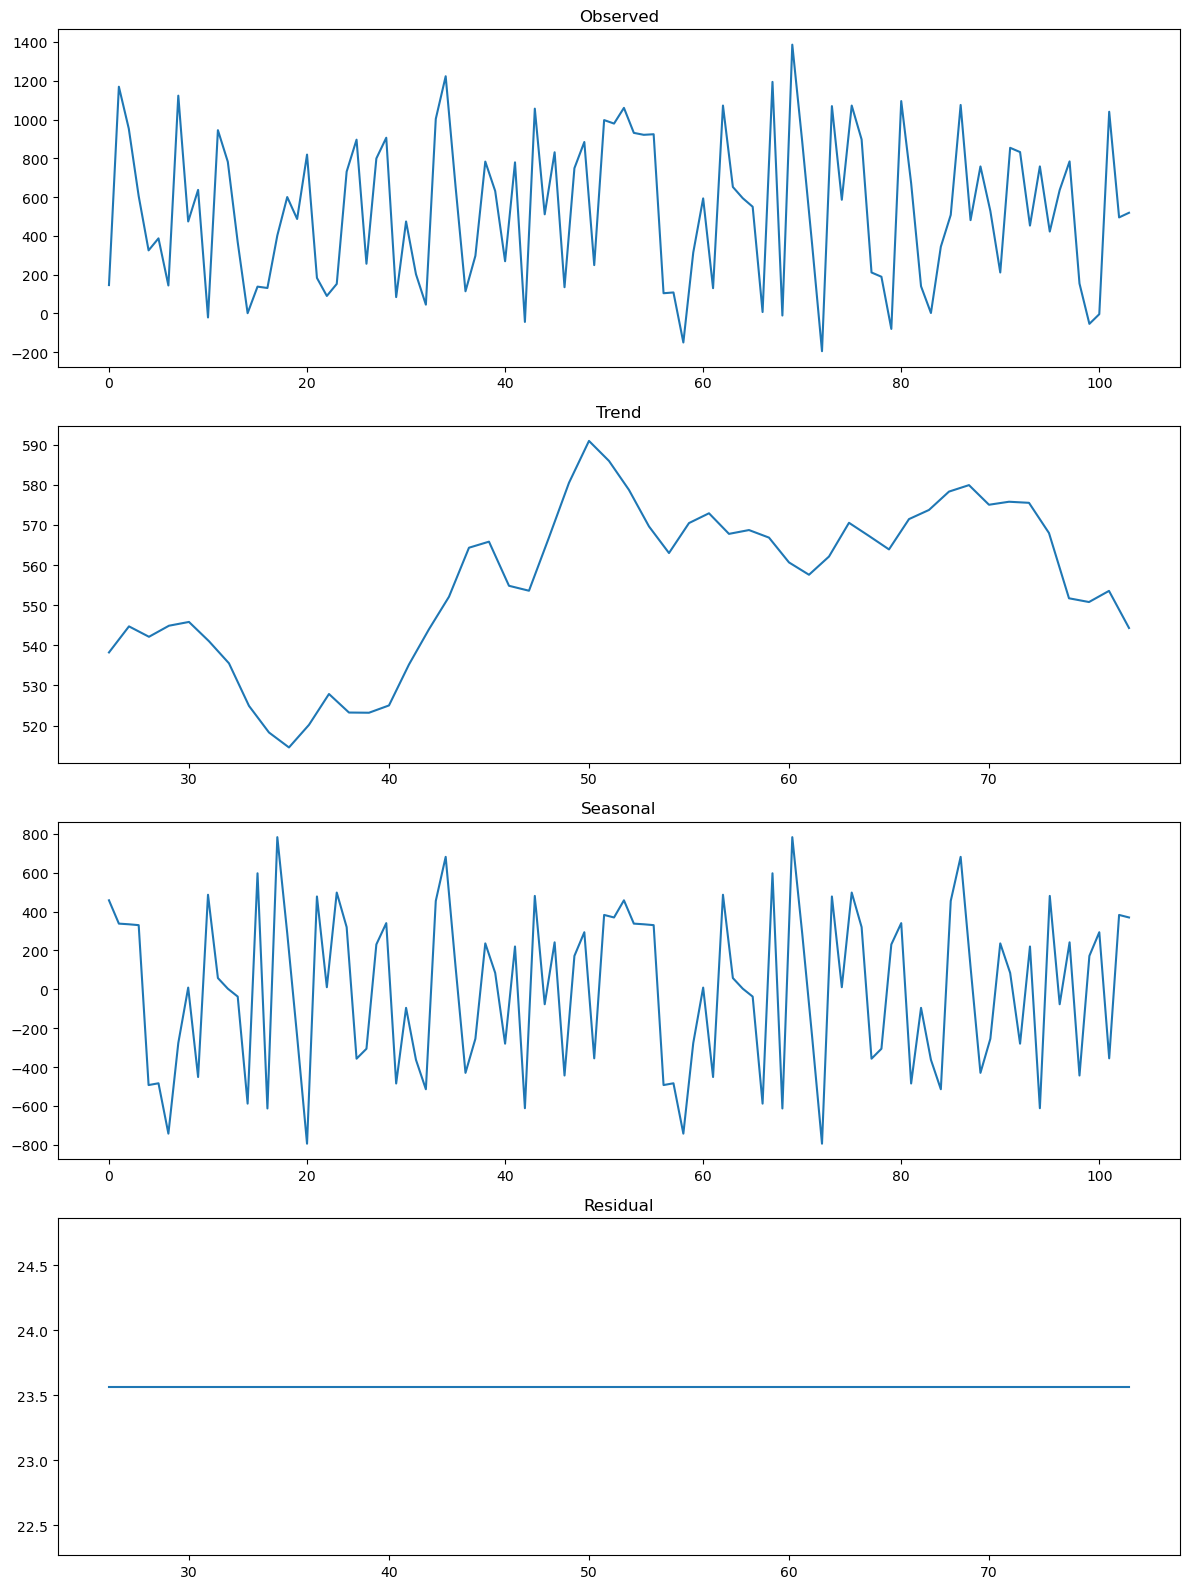

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

# 시계열 분해
decomposition = seasonal_decompose(data['Conversions'], model='additive', period=52)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

# 시계열 조정: 시즌성 제거
data['Adjusted_Conversions'] = data['Conversions'] - decomposition.seasonal


## 4. 회귀 분석

이제 시계열 조정된 데이터를 사용하여 회귀 분석을 수행합니다. 이를 통해 각 마케팅 활동이 전환 가입자 수에 미치는 영향을 파악할 수 있습니다.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# 데이터 준비
X = data[['PromoSpend', 'CompetitorPromoSpend', 'Discounts', 'Benefits']]
y = data['Adjusted_Conversions']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

# 계수 해석
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_}).set_index('Feature').sort_values('Coefficient', ascending=False)
print("\nFeature Coefficients:")
coefficients

R-squared: 0.2420
Mean Squared Error: 106395.6657

Feature Coefficients:


,Coefficient
Feature,
Discounts,1.872806
PromoSpend,0.126244
CompetitorPromoSpend,-0.088614
Benefits,-0.467537



## 5. 결과 해석 및 비즈니스 인사이트

마지막으로, 우리의 분석 결과를 해석하고 이를 비즈니스 인사이트로 연결해보겠습니다. 여기서는 Waterfall 차트를 사용하여 각 마케팅 활동의 기여 효과를 시각화합니다.


In [4]:
import plotly.graph_objects as go

# X의 평균값 계산
X_mean = X.mean().to_frame().reset_index()
X_mean.columns = ['Feature', 'Mean']

# coefficients와 X_mean을 병합
merged = coefficients.reset_index().merge(X_mean, on='Feature', how='left')

# 평균 효과 계산
merged['Effect'] = merged['Coefficient'] * merged['Mean']
mean_effects = merged.set_index('Feature')['Effect']
mean_effects = mean_effects.sort_values(ascending=False)

# Waterfall 차트 생성
fig = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = ["relative"] * len(mean_effects),
    x = mean_effects.index,
    textposition = "outside",
    text = [f"{x:.2f}" for x in mean_effects],
    y = mean_effects,
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))
fig.update_layout(
    title = "Marketing Mix Model: Contribution of Each Factor",
    showlegend = False
)
fig.show()


## 6. 분석을 통한 의사결정

이 분석을 통해 얻은 결과는 다양한 비즈니스 의사결정에 활용될 수 있습니다.

1. **마케팅 예산 배분**: 각 마케팅 요소의 기여도를 파악하여, 예산을 효율적으로 배분할 수 있습니다.
2. **경쟁사 대응 전략**: 경쟁사 프로모션이 전환 가입자 수에 미치는 영향을 분석하여, 효과적인 대응 전략을 수립할 수 있습니다.
3. **프로모션 최적화**: 특정 요금제에 대한 할인이나 혜택 제공이 전환 가입자 수에 미치는 영향을 분석하여, 최적의 프로모션 전략을 수립할 수 있습니다.